Import various PREFFECT classes

In [ ]:
import sys
import numpy as np
import torch

# path to main PREFFECT folder
sys.path.insert(0, './preffect')
from _config import configs # importing configuration from `_config.py`
from preffect_factory import factory
from _inference import( Inference )
from wrappers._cluster import( Cluster )

# limit threads
num_processors = 2
torch.set_num_threads(num_processors)
torch.set_num_interop_threads(num_processors)

Set config files. 

(PREFFECT can also be configured in `_config.py`)

In [ ]:
# set up cuda (GPUs)
configs['no_cuda'] = False
configs['cuda_device_num'] = 6

## code that reflects the exact conditions of a specific run
configs['task'] = 'train'
configs['logging_interval'] = 1
configs['seed'] = None
configs['epsilon'] = 1e-10
configs['use_pretrain'] = False
configs['pretrain_model_path'] = None
configs['unit_tests'] = False
configs['number_padded'] = 0
configs['save_training_session'] = True


# delay certain losses to later epochs
configs['delay_kl_lib'] = 1
configs['delay_kl_As'] = 1
configs['delay_kl_simple'] = 1
configs['delay_recon_As'] = 1
configs['delay_recon_expr'] = 1
configs['delay_centroid_batch'] = 1

# number of tissues to include ("full" type only)
configs['calT'] = 2
configs['type'] = 'full' # 'simple', 'single' or 'full'


# latent space size
configs['h'] = 8
configs['r_prime'] = 50
configs['r'] = 20
configs['r_embed'] = 5

# Variables which prevent extreme values
configs['clamp_value'] = 162754
configs['mid_clamp_value'] = 22026
configs['lib_clamp_value'] = 20
configs['small_clamp_value'] = 10
configs['theta_transform'] = True
configs['gradient_clip'] = True


# set input/output data
configs['input_anndata_path'] = './preffect/vignettes/full/'
configs['input_inference_anndata_path'] = configs['input_anndata_path'] + 'train/'
configs['input_existing_session'] = 'simple_py_direct'
configs['output_path'] = '/path/to/outfile/'
configs['log_path'] = configs['output_path'] + 'logs/'
configs['inference_path'] = configs['output_path'] + '/inference/'
configs['results_path'] = configs['output_path'] + '/results/'


# weights
configs['kl_weight'] = 1
configs['DA_recon_weight'] = [100, 100]
configs['X_recon_weight'] = 100

configs['simple_KL_weight'] = [0.1]
configs['DA_KL_weight'] = [0.1, 0.1]
configs['X_KL_weight'] = [0.1, 0.1]

# weights for sample-sample adjacency edges
configs['pos_edge_weight'] = 1
configs['neg_edge_weight'] = 1

# weights that only apply when reconstructing library size
configs['lib_recon_weight'] = [100, 100]
configs['DL_KL_weight'] = [0.1, 0.1]

# weights for batch centroid adjustment option
configs['batch_centroid_weight'] = [1, 1]

# learning parameters
configs['mini_batch_size'] = 50
configs['epochs'] = 1000

configs['lr'] = 0.0005
configs['weight_decay'] = 0.0005
configs['dropout'] = 0.1
configs['alpha'] = 0.2

configs['model_likelihood'] = 'NB'
configs['dispersion'] = 'gene-sample'

configs['infer_lib_size'] = False
configs['batch_centroid_loss'] = False

# Setting number of genes or samples to use (float('inf') uses all available data)
configs['select_samples'] = float('inf') # currently does not work for full models!

configs['select_sample_replacement'] = False
configs['select_genes'] = float('inf')

## Include additional variables within the model
configs['correct_vars'] = True
configs['vars_to_correct'] = [('batch', 'categorical')]

# adjusting model for batch effects (relevant during inference only; must add batch to 'vars_to_correct' for proper function)
configs['adjust_vars'] = False
configs['adjust_to_batch_level'] = 0

# Data Masking (MCARS)
configs['masking_strategy'] = None # None or 'MCAR'
configs['lambda_counts'] = 0.1
configs['lambda_edges'] = 0.0

Train your model. 

Training Progress: 100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


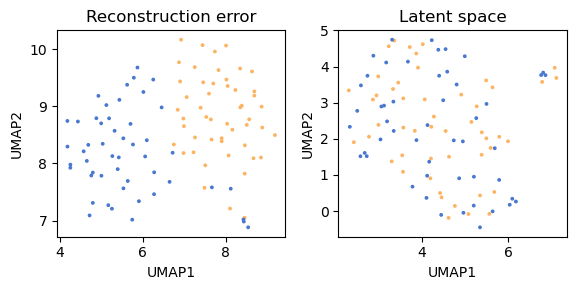

In [3]:
preffect_object = factory(
    configs=configs.copy(), 
    task='train', 
    always_save = True
)

Import inferred results as an AnnData structure

In [4]:
# PREFFECT automatically performs endogenous inference after training, which can be found within `preffect_object.inference_dict['endogenous']`
inf_obj = preffect_object.inference_dict['endogenous']
adata_test = inf_obj.return_counts_as_anndata()
print(adata_test[0].var)

              gene  mu_batch1  theta_batch1  mu_batch2  theta_batch2
Gene_1      Gene_1  10.338759             1  56.750773             1
Gene_2      Gene_2  43.673077             1  60.125970             1
Gene_3      Gene_3  38.212429             1  53.726516             1
Gene_4      Gene_4   6.797485             1  44.607416             1
Gene_5      Gene_5  39.004040             1  63.256159             1
...            ...        ...           ...        ...           ...
Gene_96    Gene_96  29.056347             1  57.036965             1
Gene_97    Gene_97  59.127575             1  52.510492             1
Gene_98    Gene_98  20.017761             1  84.858389             1
Gene_99    Gene_99  16.279935             1  68.338168             1
Gene_100  Gene_100  20.584238             1  46.953557             1

[100 rows x 5 columns]


We create a UMAP of the counts used as input to derive the PREFFECT model.

/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


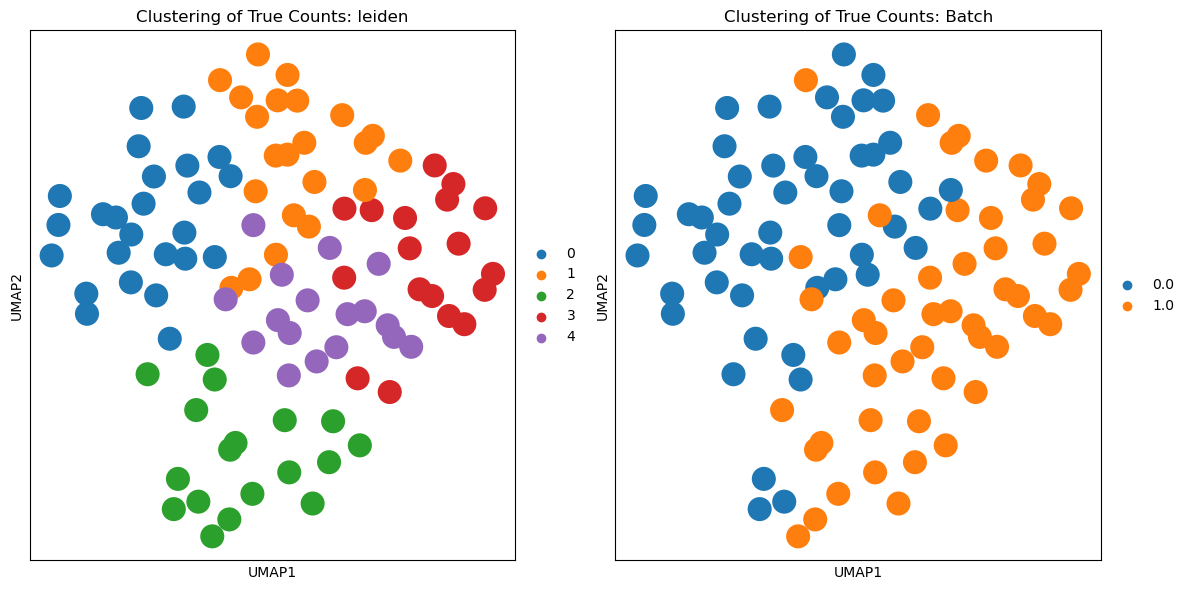

In [5]:
# Cluster counts used as input when training the PREFFECT model (observed or "true" counts)
factory(
    task='cluster_true_counts', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )


Now we cluster the counts inferred by the PREFFECT model after endogenous inference.

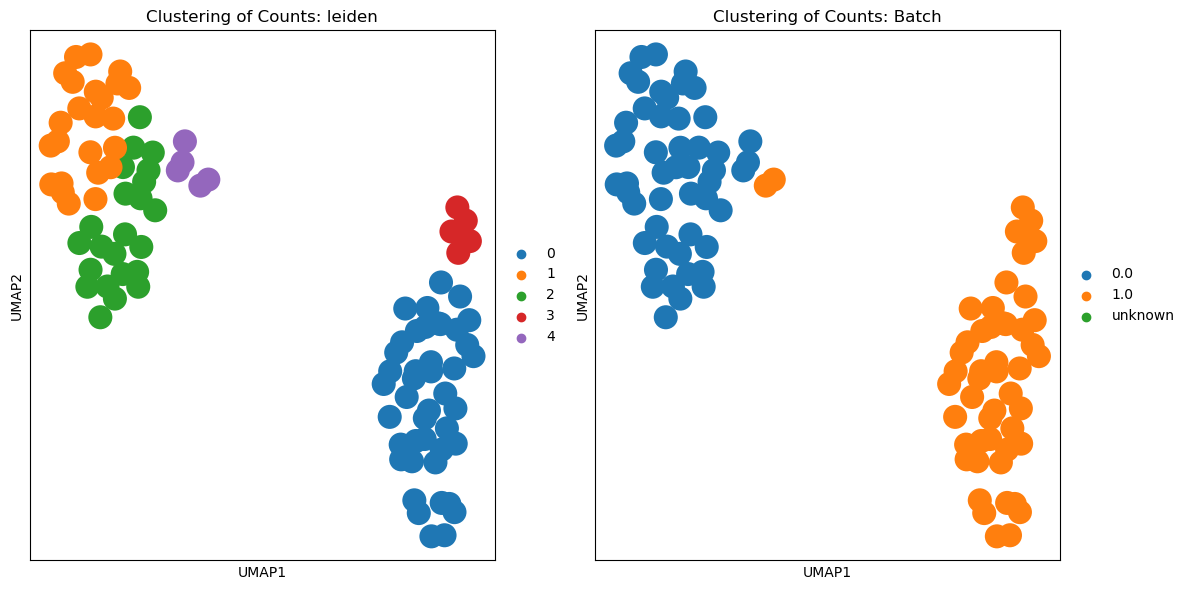

In [6]:
# Cluster counts estimated by the PREFFECT model
factory(
    task='cluster_counts', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )

We can similarly visualize the latent space in this way.

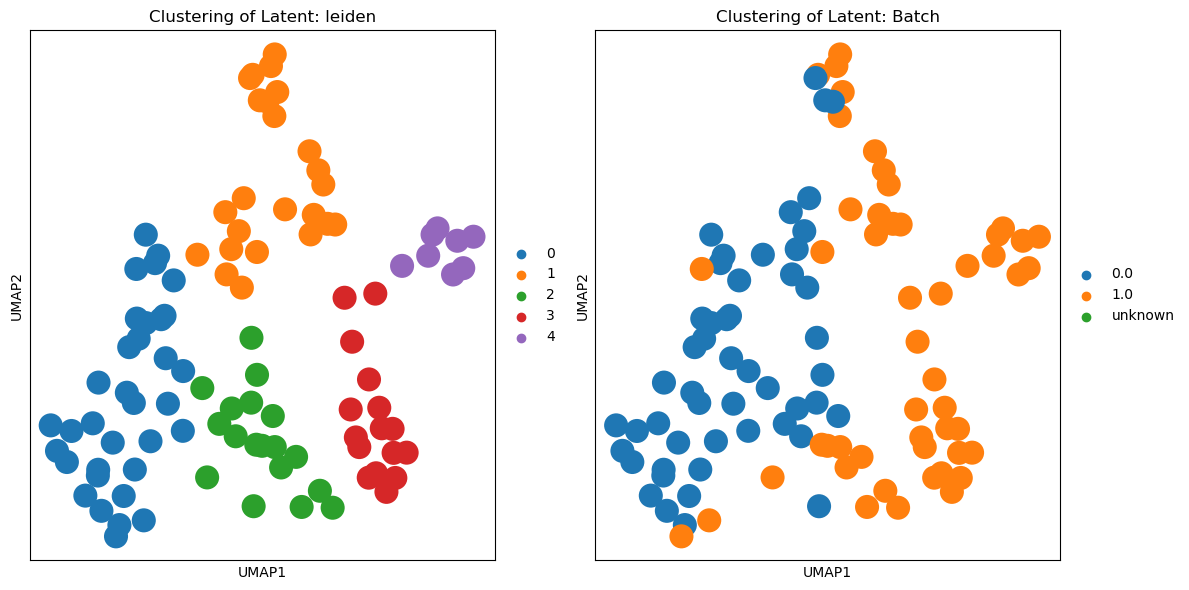

<Figure size 640x480 with 0 Axes>

In [10]:
# Cluster the latent space of expression
factory(
    task='cluster_latent', 
    preffect_obj=preffect_object, 
    inference_key='endogenous', 
    trigger_setup=False, 
    configs=configs
    )

# you can also call the clustering functions directly, which allows you to modify some of the UMAP parameters
# inference_object = preffect_object.inference_dict['endogenous'] 
# cl = Cluster(infer_obj=inference_object, configs_cluster=configs)
# cl.cluster_latent_space(color_by = "leiden", umap_nneighbors=10, cluster_aim=5)

Adjust the model to treat all samples being passed through it as if it were derived from a particular batch.

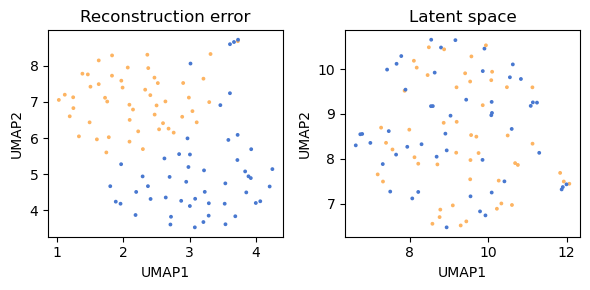

In [8]:
configs['adjust_vars'] = True, 
configs['adjust_to_batch_level'] = 0.0
 
inference_object = factory(
    task='inference', 
    configs=configs, 
    preffect_obj=preffect_object
)